## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from keras.datasets import cifar10
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
from keras.utils import np_utils
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf 
optimizer_set = [tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 tf.keras.optimizers.Adam(lr=LEARNING_RATE),
                 tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3]
redice_lr_patient = [8, 3]

C:\1_220107_Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\1_220107_Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\1_220107_Anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
import itertools
import numpy as np
mask = np.zeros((50000,3072),dtype='uint8')
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("%s-factor-%f-patient-%f" % (i, reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 8
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization_27 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_28 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 

Epoch 6/25
49/49 [==============================] - 3s 69ms/step - loss: 1.6586 - accuracy: 0.4177 - val_loss: 1.7263 - val_accuracy: 0.3899 - lr: 3.0000e-04
Epoch 7/25
49/49 [==============================] - 3s 70ms/step - loss: 1.6234 - accuracy: 0.4314 - val_loss: 1.6864 - val_accuracy: 0.4042 - lr: 3.0000e-04
Epoch 8/25
49/49 [==============================] - 3s 70ms/step - loss: 1.5917 - accuracy: 0.4424 - val_loss: 1.6624 - val_accuracy: 0.4133 - lr: 3.0000e-04
Epoch 9/25
49/49 [==============================] - 3s 71ms/step - loss: 1.5644 - accuracy: 0.4524 - val_loss: 1.6395 - val_accuracy: 0.4212 - lr: 3.0000e-04
Epoch 10/25
49/49 [==============================] - 3s 69ms/step - loss: 1.5411 - accuracy: 0.4603 - val_loss: 1.6231 - val_accuracy: 0.4299 - lr: 3.0000e-04
Epoch 11/25
49/49 [==============================] - 3s 69ms/step - loss: 1.5198 - accuracy: 0.4680 - val_loss: 1.6144 - val_accuracy: 0.4327 - lr: 3.0000e-04
Epoch 12/25
49/49 [==============================]

Epoch 22/25
49/49 [==============================] - 4s 72ms/step - loss: 1.3580 - accuracy: 0.5272 - val_loss: 1.5581 - val_accuracy: 0.4545 - lr: 3.0000e-04
Epoch 23/25
49/49 [==============================] - 3s 70ms/step - loss: 1.3468 - accuracy: 0.5318 - val_loss: 1.5573 - val_accuracy: 0.4576 - lr: 3.0000e-04
Epoch 24/25
49/49 [==============================] - 4s 73ms/step - loss: 1.3353 - accuracy: 0.5363 - val_loss: 1.5472 - val_accuracy: 0.4567 - lr: 3.0000e-04
Epoch 25/25
49/49 [==============================] - 4s 84ms/step - loss: 1.3256 - accuracy: 0.5389 - val_loss: 1.5432 - val_accuracy: 0.4577 - lr: 3.0000e-04
Numbers of exp: 3, reduce_factor: 0.30, reduce_patient: 3
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)  

Epoch 2/25
49/49 [==============================] - 4s 72ms/step - loss: 1.5049 - accuracy: 0.4678 - val_loss: 1.9628 - val_accuracy: 0.3060 - lr: 5.0000e-04
Epoch 3/25
49/49 [==============================] - 3s 71ms/step - loss: 1.4046 - accuracy: 0.5013 - val_loss: 1.6061 - val_accuracy: 0.4342 - lr: 5.0000e-04
Epoch 4/25
49/49 [==============================] - 4s 72ms/step - loss: 1.3296 - accuracy: 0.5322 - val_loss: 1.6351 - val_accuracy: 0.4113 - lr: 5.0000e-04
Epoch 5/25
49/49 [==============================] - 4s 72ms/step - loss: 1.2664 - accuracy: 0.5529 - val_loss: 1.6008 - val_accuracy: 0.4339 - lr: 5.0000e-04
Epoch 6/25
49/49 [==============================] - 4s 73ms/step - loss: 1.2130 - accuracy: 0.5712 - val_loss: 1.6692 - val_accuracy: 0.4123 - lr: 5.0000e-04
Epoch 7/25
49/49 [==============================] - 4s 73ms/step - loss: 1.1640 - accuracy: 0.5902 - val_loss: 1.6614 - val_accuracy: 0.4198 - lr: 5.0000e-04
Epoch 8/25
49/49 [==============================] - 

Epoch 15/25
49/49 [==============================] - 4s 72ms/step - loss: 0.8534 - accuracy: 0.7124 - val_loss: 1.3399 - val_accuracy: 0.5362 - lr: 6.2500e-05
Epoch 16/25
49/49 [==============================] - 4s 73ms/step - loss: 0.8373 - accuracy: 0.7202 - val_loss: 1.3583 - val_accuracy: 0.5358 - lr: 6.2500e-05
Epoch 17/25
49/49 [==============================] - 4s 72ms/step - loss: 0.8272 - accuracy: 0.7236 - val_loss: 1.3559 - val_accuracy: 0.5327 - lr: 6.2500e-05
Epoch 18/25
48/49 [============================>.] - ETA: 0s - loss: 0.8143 - accuracy: 0.7283
Epoch 18: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
49/49 [==============================] - 4s 71ms/step - loss: 0.8148 - accuracy: 0.7278 - val_loss: 1.3536 - val_accuracy: 0.5328 - lr: 6.2500e-05
Epoch 19/25
49/49 [==============================] - 3s 71ms/step - loss: 0.7975 - accuracy: 0.7359 - val_loss: 1.3443 - val_accuracy: 0.5370 - lr: 3.1250e-05
Epoch 20/25
49/49 [==========================

 input_17 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization_48 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_49 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_50 (Bat  (None, 256)              1024      
 chNormali

Epoch 8/25
49/49 [==============================] - 4s 79ms/step - loss: 1.1208 - accuracy: 0.6038 - val_loss: 1.6706 - val_accuracy: 0.4208 - lr: 0.0010
Epoch 9/25
49/49 [==============================] - 4s 77ms/step - loss: 1.0777 - accuracy: 0.6195 - val_loss: 1.6504 - val_accuracy: 0.4282 - lr: 0.0010
Epoch 10/25
49/49 [==============================] - 4s 78ms/step - loss: 1.0332 - accuracy: 0.6357 - val_loss: 1.5972 - val_accuracy: 0.4462 - lr: 0.0010
Epoch 11/25
49/49 [==============================] - 4s 77ms/step - loss: 0.9997 - accuracy: 0.6495 - val_loss: 1.9329 - val_accuracy: 0.3686 - lr: 0.0010
Epoch 12/25
49/49 [==============================] - 4s 77ms/step - loss: 0.9594 - accuracy: 0.6629 - val_loss: 1.5672 - val_accuracy: 0.4620 - lr: 0.0010
Epoch 13/25
49/49 [==============================] - 4s 77ms/step - loss: 0.9220 - accuracy: 0.6791 - val_loss: 1.5310 - val_accuracy: 0.4786 - lr: 0.0010
Epoch 14/25
49/49 [==============================] - 4s 77ms/step - loss

49/49 [==============================] - 4s 75ms/step - loss: 0.6890 - accuracy: 0.7825 - val_loss: 1.3894 - val_accuracy: 0.5332 - lr: 6.2500e-05
Epoch 21/25
49/49 [==============================] - 4s 76ms/step - loss: 0.6799 - accuracy: 0.7855 - val_loss: 1.3844 - val_accuracy: 0.5293 - lr: 6.2500e-05
Epoch 22/25
49/49 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7872
Epoch 22: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
49/49 [==============================] - 4s 75ms/step - loss: 0.6705 - accuracy: 0.7872 - val_loss: 1.4057 - val_accuracy: 0.5265 - lr: 6.2500e-05
Epoch 23/25
49/49 [==============================] - 4s 75ms/step - loss: 0.6544 - accuracy: 0.7950 - val_loss: 1.3804 - val_accuracy: 0.5365 - lr: 3.1250e-05
Epoch 24/25
49/49 [==============================] - 4s 76ms/step - loss: 0.6479 - accuracy: 0.7972 - val_loss: 1.3800 - val_accuracy: 0.5382 - lr: 3.1250e-05
Epoch 25/25
49/49 [==============================] - ETA:

 chNormalization)                                                
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 923,914
Trainable params: 922,378
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/25
49/49 [==============================] - 6s 83ms/step - loss: 2.5141 - accuracy: 0.1969 - val_loss: 2.2305 - val_accuracy: 0.1872 - lr: 1.5625e-05
Epoch 2/25
49/49 [==============================] - 4s 75ms/step - loss: 2.1468 - accuracy: 0.2824 - val_loss: 2.1435 - val_accuracy: 0.2349 - lr: 1.5625e-05
Epoch 3/25
49/49 [==============================] - 4s 75ms/step - loss: 1.9854 - accuracy: 0.3254 - val_loss: 2.0445 - val_accuracy: 0.2866 - lr: 1.5625e-05
Epoch 4/25
49/49 [==============================] - 4s 75ms/step - loss: 1.8867 - accuracy: 0.3522 - val_loss: 1.9550 - 

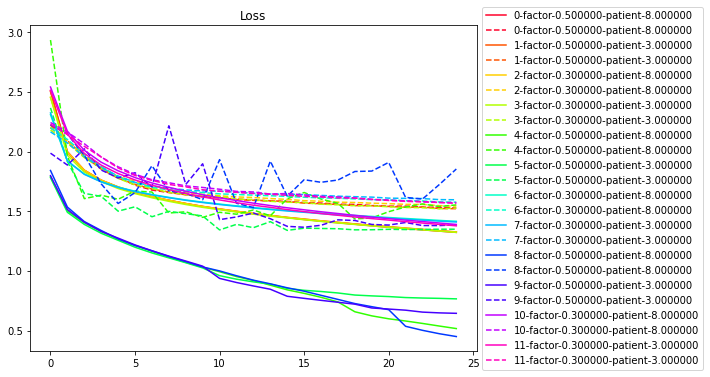

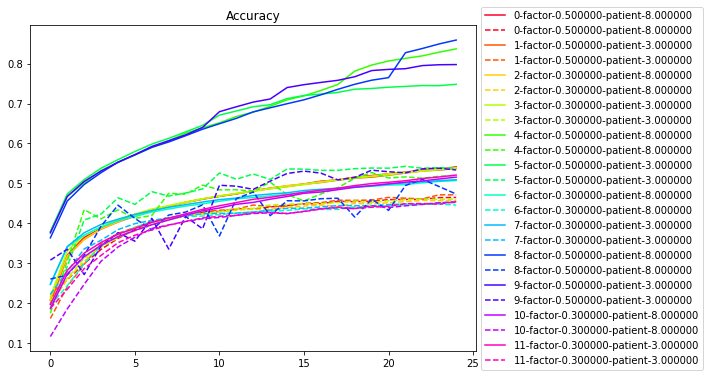

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()